In [2]:
import numpy as np
c = np.array([[1, 0, 0, 0, 0, 0, 0]]) # 输入
W = np.random.randn(7, 3) # 权重
h = np.dot(c, W) # 中间节点


In [3]:
h

array([[-0.83273494,  1.55982877,  0.1579545 ]])

这段代码将单词 ID 为 0 的单词表示为了 one-hot 表示，并用全连接层
对其进行了变换。作为复习，全连接层的计算通过矩阵乘积进行。这可以用
NumPy 的 np.dot() 来实现（省略偏置）

这里，输入数据（变量c）的维数（ndim）是2。这是考虑了mini-batch
处理，将各个数据保存在了第 1 维（0 维度）中。

# CBOW模型的实现

In [1]:
# coding: utf-8
import sys
sys.path.append('..')
import os
import numpy as np

In [2]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word




In [22]:
def create_contexts_target(corpus, window_size=1):
    '''生成上下文和目标词

    :param corpus: 语料库（单词ID列表）
    :param window_size: 窗口大小（当窗口大小为1时，左右各1个单词为上下文）
    :return:
    '''
    target = corpus[window_size:-window_size]
    contexts = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)


In [3]:
def convert_one_hot(corpus, vocab_size):
    '''转换为one-hot表示

    :param corpus: 单词ID列表（一维或二维的NumPy数组）
    :param vocab_size: 词汇个数
    :return: one-hot表示（二维或三维的NumPy数组）
    '''
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot



In [4]:
#trainer部分会用的此函数

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate

接下来是trainer文件

In [5]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy
import time
import matplotlib.pyplot as plt
import numpy as np
#from common.util import clip_grads


Trainer 类会执行神经
网络的学习过程，包括从学习数据中选出 mini-batch 给神经网络以算出梯
度，并将这个梯度给优化器以更新权重参数等一系列操作。

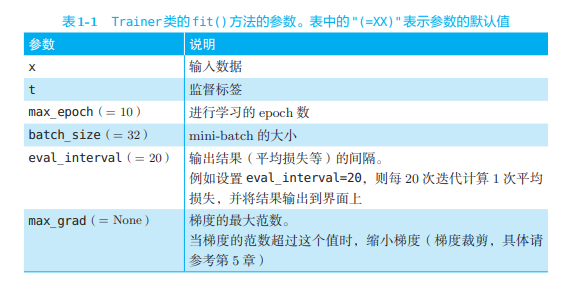

另外，Trainer 类有 plot() 方法，它将 fit() 方法记录的损失（准确地
说，是按照 eval_interval 评价的平均损失）在图上画出来。

In [6]:
class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            # 打乱
            idx = numpy.random.permutation(numpy.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

                # 计算梯度，更新参数
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 将共享的权重整合为1个
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 评价
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print('| epoch %d |  iter %d / %d | time %d[s] | loss %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1
        #画图损失函数
    def plot(self, ylim=None):
        x = numpy.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
        plt.ylabel('loss')
        plt.show()

In [7]:
class RnnlmTrainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.time_idx = None
        self.ppl_list = None
        self.eval_interval = None
        self.current_epoch = 0

    def get_batch(self, x, t, batch_size, time_size):
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')

        data_size = len(x)
        jump = data_size // batch_size
        offsets = [i * jump for i in range(batch_size)]  # mini-batch的各笔样本数据的开始位置

        for time in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, time] = x[(offset + self.time_idx) % data_size]
                batch_t[i, time] = t[(offset + self.time_idx) % data_size]
            self.time_idx += 1
        return batch_x, batch_t

    def fit(self, xs, ts, max_epoch=10, batch_size=20, time_size=35,
            max_grad=None, eval_interval=20):
        data_size = len(xs)
        max_iters = data_size // (batch_size * time_size)
        self.time_idx = 0
        self.ppl_list = []
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            for iters in range(max_iters):
                batch_x, batch_t = self.get_batch(xs, ts, batch_size, time_size)

                # 计算梯度，更新参数
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 将共享的权重整合为1个
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 评价困惑度
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    ppl = np.exp(total_loss / loss_count)
                    elapsed_time = time.time() - start_time
                    print('| epoch %d |  iter %d / %d | time %d[s] | perplexity %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, ppl))
                    self.ppl_list.append(float(ppl))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = numpy.arange(len(self.ppl_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.ppl_list, label='train')
        plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
        plt.ylabel('perplexity')
        plt.show()



In [8]:
def remove_duplicate(params, grads):
    '''
    将参数列表中重复的权重整合为1个，
    加上与该权重对应的梯度
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 在共享权重的情况下
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 加上梯度
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 在作为转置矩阵共享权重的情况下（weight tying）
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads


之后是optimizer部分

In [9]:
import sys
sys.path.append('..')
import numpy as np


2014年12月， Kingma和Lei Ba两位学者提出了Adam优化器，结合AdaGrad和RMSProp两种优化算法的优点。对梯度的一阶矩估计（First Moment Estimation，即梯度的均值）和二阶矩估计（Second Moment Estimation，即梯度的未中心化的方差）进行综合考虑，计算出更新步长。

主要包含以下几个显著的优点：

实现简单，计算高效，对内存需求少
参数的更新不受梯度的伸缩变换影响
超参数具有很好的解释性，且通常无需调整或仅需很少的微调
更新的步长能够被限制在大致的范围内（初始学习率）
能自然地实现步长退火过程（自动调整学习率）
很适合应用于大规模的数据及参数的场景
适用于不稳定目标函数
适用于梯度稀疏或梯度存在很大噪声的问题


综合Adam在很多情况下算作默认工作性能比较优秀的优化器。

In [10]:
#本次实验用的是Adam参数更新方法
class Adam:
    '''
    Adam (http://arxiv.org/abs/1412.6980v8)
    '''
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(np.zeros_like(param))
                self.v.append(np.zeros_like(param))
        
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for i in range(len(params)):
            self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
            self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])
            
            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)


下面是simple_cbow模型

In [12]:
def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x

将矩阵乘积称为 MatMul 节点。MatMul 是 Matrix Multiply 的缩
写。

In [17]:
class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW
        return dx


In [18]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 在监督标签为one-hot-vector的情况下，转换为正确解标签的索引
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


In [19]:
# cross_entropy_error 和softmax函数在下面的会用到来构建SoftmaxWithLoss
class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmax的输出
        self.t = None  # 监督标签

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # 在监督标签为one-hot向量的情况下，转换为正确解标签的索引
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx

我们将 Softmax 函数和交叉熵误差一起实现为 Softmax with Loss 层。

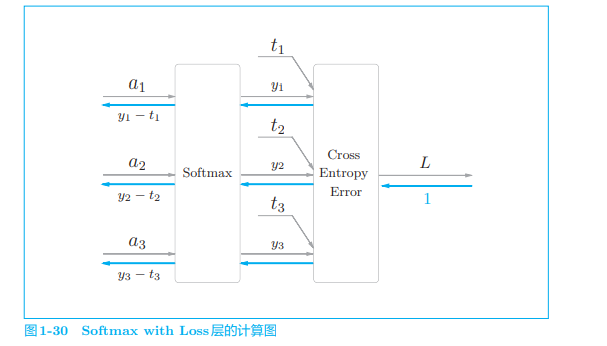

Softmax 层对输入 a1, a2, a3 进行正规化，输出 y1, 
y2, y3。Cross Entropy Error 层接收 Softmax 的输出 y1, y2, y3 和监督标签
t1, t2, t3，并基于这些数据输出损失 L。

 SoftmaxWithLoss 和MatMul层在搭建SimpleCBOW模型时会调用到

In [20]:
class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 初始化权重
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 生成层
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # 将所有的权重和梯度整理到列表中
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 将单词的分布式表示设置为成员变量
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None


学习的实现
CBOW 模型的学习和一般的神经网络的学习完全相同。首先，给神
经网络准备好学习数据。然后，求梯度，并逐步更新权重参数。

此为主程序，会调用前面的 preprocess 函数（预处理），create_contexts_target，convert_one_hot，simpleCBOW为主要模型，Adam为优化器，Trainer为整个训练模块

In [23]:
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
#trainer.plot()

#word_vecs = model.word_vecs
#for word_id, word in id_to_word.items():
  #  print(word, word_vecs[word_id])

| epoch 1 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 21 |  iter 1 / 2 | ti

| epoch 430 |  iter 1 / 2 | time 0[s] | loss 0.52
| epoch 431 |  iter 1 / 2 | time 0[s] | loss 0.66
| epoch 432 |  iter 1 / 2 | time 0[s] | loss 0.68
| epoch 433 |  iter 1 / 2 | time 0[s] | loss 0.64
| epoch 434 |  iter 1 / 2 | time 0[s] | loss 0.62
| epoch 435 |  iter 1 / 2 | time 0[s] | loss 0.53
| epoch 436 |  iter 1 / 2 | time 0[s] | loss 0.69
| epoch 437 |  iter 1 / 2 | time 0[s] | loss 0.54
| epoch 438 |  iter 1 / 2 | time 0[s] | loss 0.63
| epoch 439 |  iter 1 / 2 | time 0[s] | loss 0.69
| epoch 440 |  iter 1 / 2 | time 0[s] | loss 0.54
| epoch 441 |  iter 1 / 2 | time 0[s] | loss 0.61
| epoch 442 |  iter 1 / 2 | time 0[s] | loss 0.61
| epoch 443 |  iter 1 / 2 | time 0[s] | loss 0.67
| epoch 444 |  iter 1 / 2 | time 0[s] | loss 0.61
| epoch 445 |  iter 1 / 2 | time 0[s] | loss 0.55
| epoch 446 |  iter 1 / 2 | time 0[s] | loss 0.68
| epoch 447 |  iter 1 / 2 | time 0[s] | loss 0.60
| epoch 448 |  iter 1 / 2 | time 0[s] | loss 0.68
| epoch 449 |  iter 1 / 2 | time 0[s] | loss 0.53


| epoch 888 |  iter 1 / 2 | time 0[s] | loss 0.22
| epoch 889 |  iter 1 / 2 | time 0[s] | loss 0.44
| epoch 890 |  iter 1 / 2 | time 0[s] | loss 0.32
| epoch 891 |  iter 1 / 2 | time 0[s] | loss 0.21
| epoch 892 |  iter 1 / 2 | time 0[s] | loss 0.44
| epoch 893 |  iter 1 / 2 | time 0[s] | loss 0.32
| epoch 894 |  iter 1 / 2 | time 0[s] | loss 0.20
| epoch 895 |  iter 1 / 2 | time 0[s] | loss 0.43
| epoch 896 |  iter 1 / 2 | time 0[s] | loss 0.34
| epoch 897 |  iter 1 / 2 | time 0[s] | loss 0.30
| epoch 898 |  iter 1 / 2 | time 0[s] | loss 0.32
| epoch 899 |  iter 1 / 2 | time 0[s] | loss 0.45
| epoch 900 |  iter 1 / 2 | time 0[s] | loss 0.19
| epoch 901 |  iter 1 / 2 | time 0[s] | loss 0.34
| epoch 902 |  iter 1 / 2 | time 0[s] | loss 0.40
| epoch 903 |  iter 1 / 2 | time 0[s] | loss 0.23
| epoch 904 |  iter 1 / 2 | time 0[s] | loss 0.21
| epoch 905 |  iter 1 / 2 | time 0[s] | loss 0.43
| epoch 906 |  iter 1 / 2 | time 0[s] | loss 0.21
| epoch 907 |  iter 1 / 2 | time 0[s] | loss 0.41


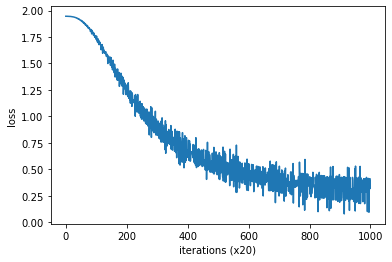

In [24]:
trainer.plot()

通过不断学习，损失在减小，看起来学习进行得一
切正常。我们来看一下学习结束后的权重参数。这里，我们取出输入侧的
MatMul 层的权重，实际确认一下它的内容。因为输入侧的 MatMul 层的权
重已经赋值给了成员变量 word_vecs，所以接着上面的代码，我们追加下面
的代码。

In [25]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [ 1.7455283   0.90320337 -0.91071117 -1.0928724  -0.90479594]
say [ 0.34377262 -1.216337    1.1994528   0.03615259  1.2211057 ]
goodbye [-0.72169626  1.0201694  -1.0737945  -1.0159093  -1.0314862 ]
and [ 1.5608059  -0.9579345   0.94868976  1.4654931   0.95675623]
i [-0.72141486  1.007851   -1.0496238  -0.99556774 -1.0072627 ]
hello [ 1.7529273  0.9157008 -0.904967  -1.075038  -0.9412989]
. [-1.3553793 -1.0715269  1.0735321 -1.4183489  1.0555999]


这里，使用 word_vecs 这个变量保存权重。word_vecs 的各行保存了对应
的单词 ID 的分布式表示。实际运行一下，可以得到下述结果

我们终于将单词表示为了密集向量！这就是单词的分布式表示。我们有
理由相信，这样的分布式表示能够很好地捕获单词含义。
不过，遗憾的是，这里使用的小型语料库并没有给出很好的结果。当
然，主要原因是语料库太小了。如果换成更大、更实用的语料库，相信会获
得更好的结果。

下面是SkipGram的模型，和输入示例的运行结果。各位同学可以对比一下CBOW和SkipGram模型

In [26]:
class SimpleSkipGram:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 初始化权重
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 生成层
        self.in_layer = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer1 = SoftmaxWithLoss()
        self.loss_layer2 = SoftmaxWithLoss()

        # 将所有的权重和梯度整理到列表中
        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 将单词的分布式表示设置为成员变量
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)
        s = self.out_layer.forward(h)
        l1 = self.loss_layer1.forward(s, contexts[:, 0])
        l2 = self.loss_layer2.forward(s, contexts[:, 1])
        loss = l1 + l2
        return loss

    def backward(self, dout=1):
        dl1 = self.loss_layer1.backward(dout)
        dl2 = self.loss_layer2.backward(dout)
        ds = dl1 + dl2
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        return None


In [27]:
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleSkipGram(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)

| epoch 1 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 3.88
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 3.88
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 3.88
| epoch 21 |  iter 1 / 2 | ti

| epoch 380 |  iter 1 / 2 | time 0[s] | loss 2.17
| epoch 381 |  iter 1 / 2 | time 0[s] | loss 2.19
| epoch 382 |  iter 1 / 2 | time 0[s] | loss 2.09
| epoch 383 |  iter 1 / 2 | time 0[s] | loss 2.38
| epoch 384 |  iter 1 / 2 | time 0[s] | loss 1.78
| epoch 385 |  iter 1 / 2 | time 0[s] | loss 2.20
| epoch 386 |  iter 1 / 2 | time 0[s] | loss 2.31
| epoch 387 |  iter 1 / 2 | time 0[s] | loss 2.11
| epoch 388 |  iter 1 / 2 | time 0[s] | loss 2.44
| epoch 389 |  iter 1 / 2 | time 0[s] | loss 1.93
| epoch 390 |  iter 1 / 2 | time 0[s] | loss 2.08
| epoch 391 |  iter 1 / 2 | time 0[s] | loss 2.22
| epoch 392 |  iter 1 / 2 | time 0[s] | loss 2.14
| epoch 393 |  iter 1 / 2 | time 0[s] | loss 2.08
| epoch 394 |  iter 1 / 2 | time 0[s] | loss 1.96
| epoch 395 |  iter 1 / 2 | time 0[s] | loss 2.61
| epoch 396 |  iter 1 / 2 | time 0[s] | loss 2.12
| epoch 397 |  iter 1 / 2 | time 0[s] | loss 1.76
| epoch 398 |  iter 1 / 2 | time 0[s] | loss 2.32
| epoch 399 |  iter 1 / 2 | time 0[s] | loss 2.11


| epoch 756 |  iter 1 / 2 | time 0[s] | loss 1.90
| epoch 757 |  iter 1 / 2 | time 0[s] | loss 1.89
| epoch 758 |  iter 1 / 2 | time 0[s] | loss 1.69
| epoch 759 |  iter 1 / 2 | time 0[s] | loss 2.12
| epoch 760 |  iter 1 / 2 | time 0[s] | loss 1.91
| epoch 761 |  iter 1 / 2 | time 0[s] | loss 1.92
| epoch 762 |  iter 1 / 2 | time 0[s] | loss 2.12
| epoch 763 |  iter 1 / 2 | time 0[s] | loss 1.69
| epoch 764 |  iter 1 / 2 | time 0[s] | loss 1.89
| epoch 765 |  iter 1 / 2 | time 0[s] | loss 1.69
| epoch 766 |  iter 1 / 2 | time 0[s] | loss 2.35
| epoch 767 |  iter 1 / 2 | time 0[s] | loss 1.45
| epoch 768 |  iter 1 / 2 | time 0[s] | loss 1.90
| epoch 769 |  iter 1 / 2 | time 0[s] | loss 2.13
| epoch 770 |  iter 1 / 2 | time 0[s] | loss 1.90
| epoch 771 |  iter 1 / 2 | time 0[s] | loss 1.90
| epoch 772 |  iter 1 / 2 | time 0[s] | loss 1.92
| epoch 773 |  iter 1 / 2 | time 0[s] | loss 2.12
| epoch 774 |  iter 1 / 2 | time 0[s] | loss 1.67
| epoch 775 |  iter 1 / 2 | time 0[s] | loss 2.12


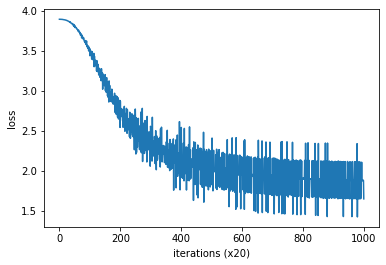

In [28]:
trainer.plot()

In [29]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [ 0.0181693  -0.00970627 -0.00342693 -0.00676046 -0.01854255]
say [ 1.0271378  -0.05093279  0.9927825  -0.39678463  1.0180335 ]
goodbye [-0.7850321 -0.9403126 -0.8120191  1.1666552 -0.7888323]
and [0.8150406  1.1909696  0.84965026 1.2376938  0.81732243]
i [-0.79310507 -0.9403894  -0.808205    1.1771295  -0.8008259 ]
hello [-1.0042892   0.5639432  -1.0200987  -0.93782145 -0.9944103 ]
. [-0.00900156 -0.01705438 -0.00504299 -0.00643278  0.0001775 ]
